# ATREE_NOTMNIST

I am doing a train-test split here, since otherwise the structure of the tree will depend on the point being evaluated. However, in an active learning scenario we do not need to do this split and just need to subtract the label of the point.

## Conclusions...

KD-Trees work terribly when splits are done directly on high-dimensional data, so must use SVD first.

In [1]:
%load_ext autoreload
%autoreload 2

In [348]:
from collections import Counter

import scipy as sp
import scipy.io
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

from kdtree import KDTree

The number of SVD components is in question.

In [415]:
INT2LABEL = np.array(list('ABCDEFGHIJ'))

data = sp.io.loadmat("notMNIST_small.mat")

images = data['images'].transpose(2, 0, 1)
samples = (2 * images.reshape(-1, 784) - 255.0) / 255.0

n_components = 25
samples = TruncatedSVD(n_components).fit_transform(samples)

labels = data['labels'].astype(int)
labels = INT2LABEL[labels]

trnI, devI, trnX, devX, trnY, devY = train_test_split(images, samples, labels, test_size=0.1)
allX = np.concatenate([trnX, devX])
allY = np.concatenate([trnY, devY])
maskY = allY.copy()
maskY[trnY.size:] = 'NA'

In [416]:
tree = KDTree(allX, maskY)

Actual point has label J


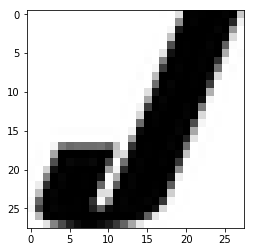

J 	 eta=0.900 	 delta=0.707 	 k=2
single tree predicted J


In [417]:
idx = np.random.randint(devY.size)
im, x, y = devI[idx], devX[idx], devY[idx]
print('Actual point has label %s' % y)
plt.imshow(im, cmap='Greys')
plt.show()

print('single tree predicted %s' % tree.get_pred(x, verbose=True))

In [401]:
def evaluate_rule(rule):
    correct = [rule(x) == y for x, y in zip(devX, devY)]
    return np.array(correct).mean()

## Accuracy of single tree

In [418]:
rule = lambda x: tree.get_pred(x, conf=1.0)
acc = evaluate_rule(rule)
print('accuracy of single atree is %.4f' % acc)

accuracy of single atree is 0.7395


## Ensemble / adaptive-forest

In [419]:
trees = [KDTree(allX, maskY) for _ in range(20)]

In [420]:
def rule(x):
    preds = [tree.get_pred(x, conf=1.0) for tree in trees]
    return Counter(preds).most_common(1)[0][0]

acc = evaluate_rule(rule)
print('accuracy of a-forest is %.4f' % acc)

accuracy of a-forest is 0.8884
